# Machine Learning for Regression problems

Neural networks are well known for classification problems, for example, they are used in handwritten digits classification, but the question is will it be fruitful if we used them for regression problems?

In this article I will use a deep neural network to predict house pricing using a dataset from Kaggle .

You can download the dataset from [Here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


Reference:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

![](https://cdn-images-1.medium.com/max/2000/1*vUKwarc7rCouMzSt0Ksakw.jpeg)

## Contents :
- 1 Process the dataset
- 2 Make the deep neural network
- 3 Train the NN
- 4 Test the NN
- 5 Compare the result from the NN to another ML algorithm

**First of all, we will import the needed dependencies :**

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

## First : Processing the dataset
We will not go deep in processing the dataset, all we want to do is getting the dataset ready to be fed into our models .

We will get rid of any features with missing values, then we will encode the categorical features, that's it.

Fore more details of the model, check, https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

### Load the dataset :
* Load train and test data into pandas DataFrames
* Combine train and test data to process them together

In [ ]:
train_data_path ='https://utilitiesfiles.s3.amazonaws.com/urban-analytic-class/train.csv'
train = pd.read_csv(train_data_path)

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
def get_data():
    #get train data
    train_data_path ='https://utilitiesfiles.s3.amazonaws.com/urban-analytic-class/train.csv'
    train = pd.read_csv(train_data_path)

    #get test data
    test_data_path ='https://utilitiesfiles.s3.amazonaws.com/urban-analytic-class/test.csv'
    test = pd.read_csv(test_data_path)

    return train , test


def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.SalePrice
  train.drop(['SalePrice'],axis = 1 , inplace = True)

  # combined = train.append(test) #deprecated in pandas 2.0.0
  combined = pd.concat([train, test], ignore_index=True)

  combined.reset_index(inplace=True)
  combined.drop(['index', 'Id'], inplace=True, axis=1)
  return combined, target


#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [ ]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


let's define a function to get the columns that don't have any missing values

In [ ]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type :
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

Get the columns that do not have any missing values .

In [ ]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

Let's see how many columns we got

In [ ]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


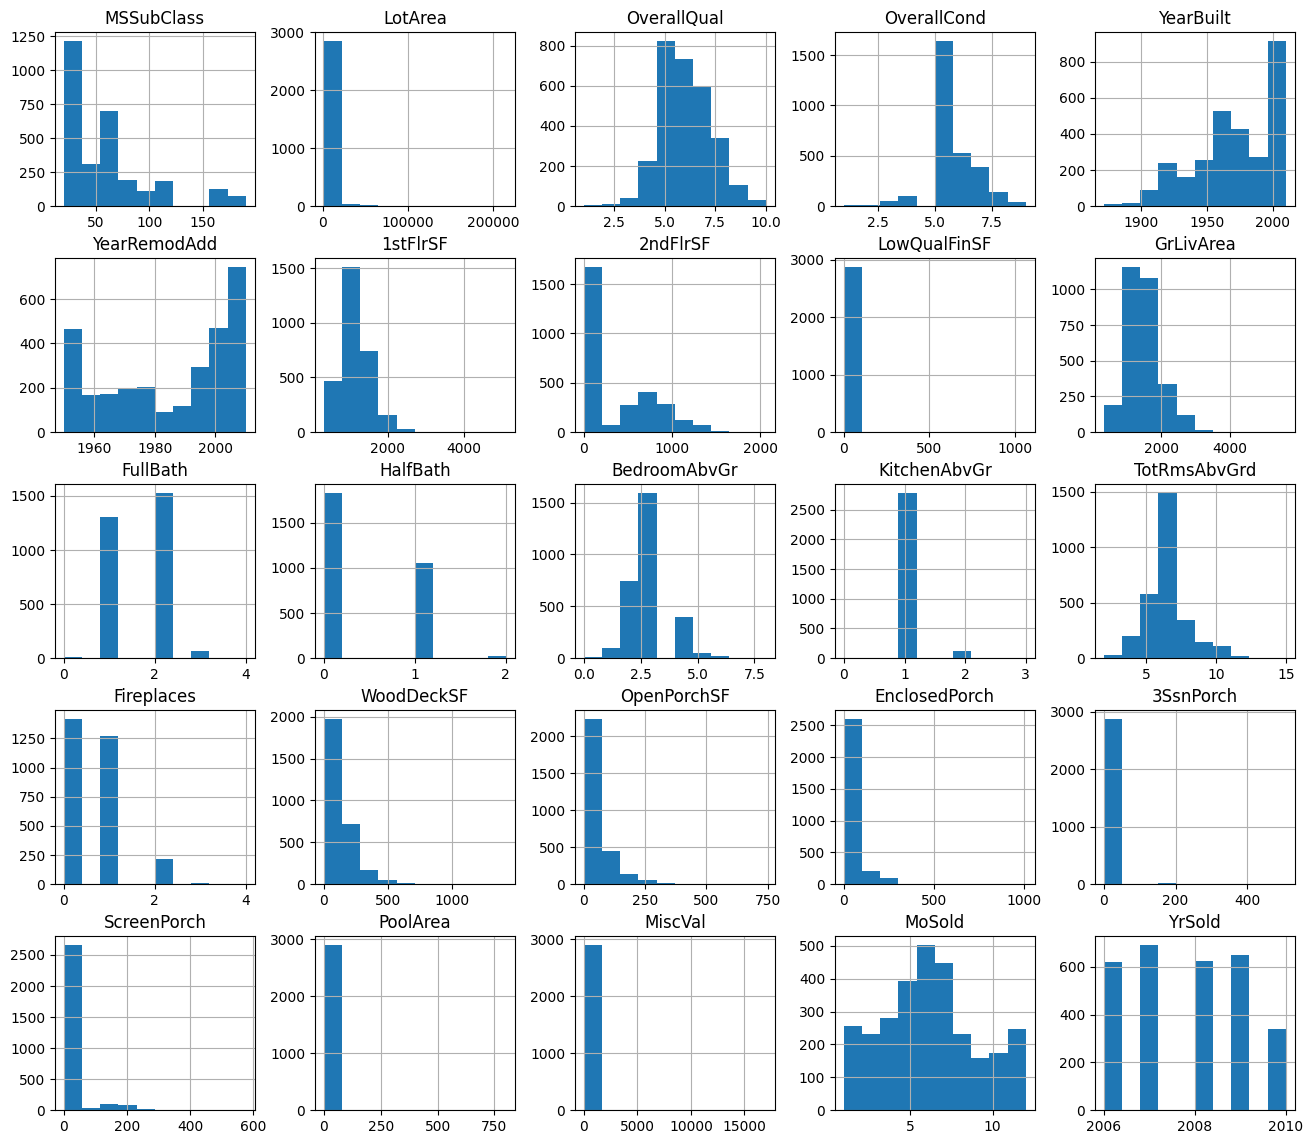

In [ ]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (16,14))
plt.show()

In [ ]:
# print(train_data.dtypes)
C_mat = train_data.select_dtypes(include=['number']).corr()
print(C_mat)


                     Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass     0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage   -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea       -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual   -0.028365    0.032628     0.251646  0.105806     1.000000   
OverallCond    0.012609   -0.059316    -0.059213 -0.005636    -0.091932   
YearBuilt     -0.012713    0.027850     0.123349  0.014228     0.572323   
YearRemodAdd  -0.021998    0.040581     0.088866  0.013788     0.550684   
MasVnrArea    -0.050298    0.022936     0.193458  0.104160     0.411876   
BsmtFinSF1    -0.005024   -0.069836     0.233633  0.214103     0.239666   
BsmtFinSF2    -0.005968   -0.065649     0.049900  0.111170    -0.059119   
BsmtUnfSF     -0.007940   -0.140759     0.132644 -0.002618     0.308159   
TotalBsmtSF   -0.015415  

**The correlation between the features**

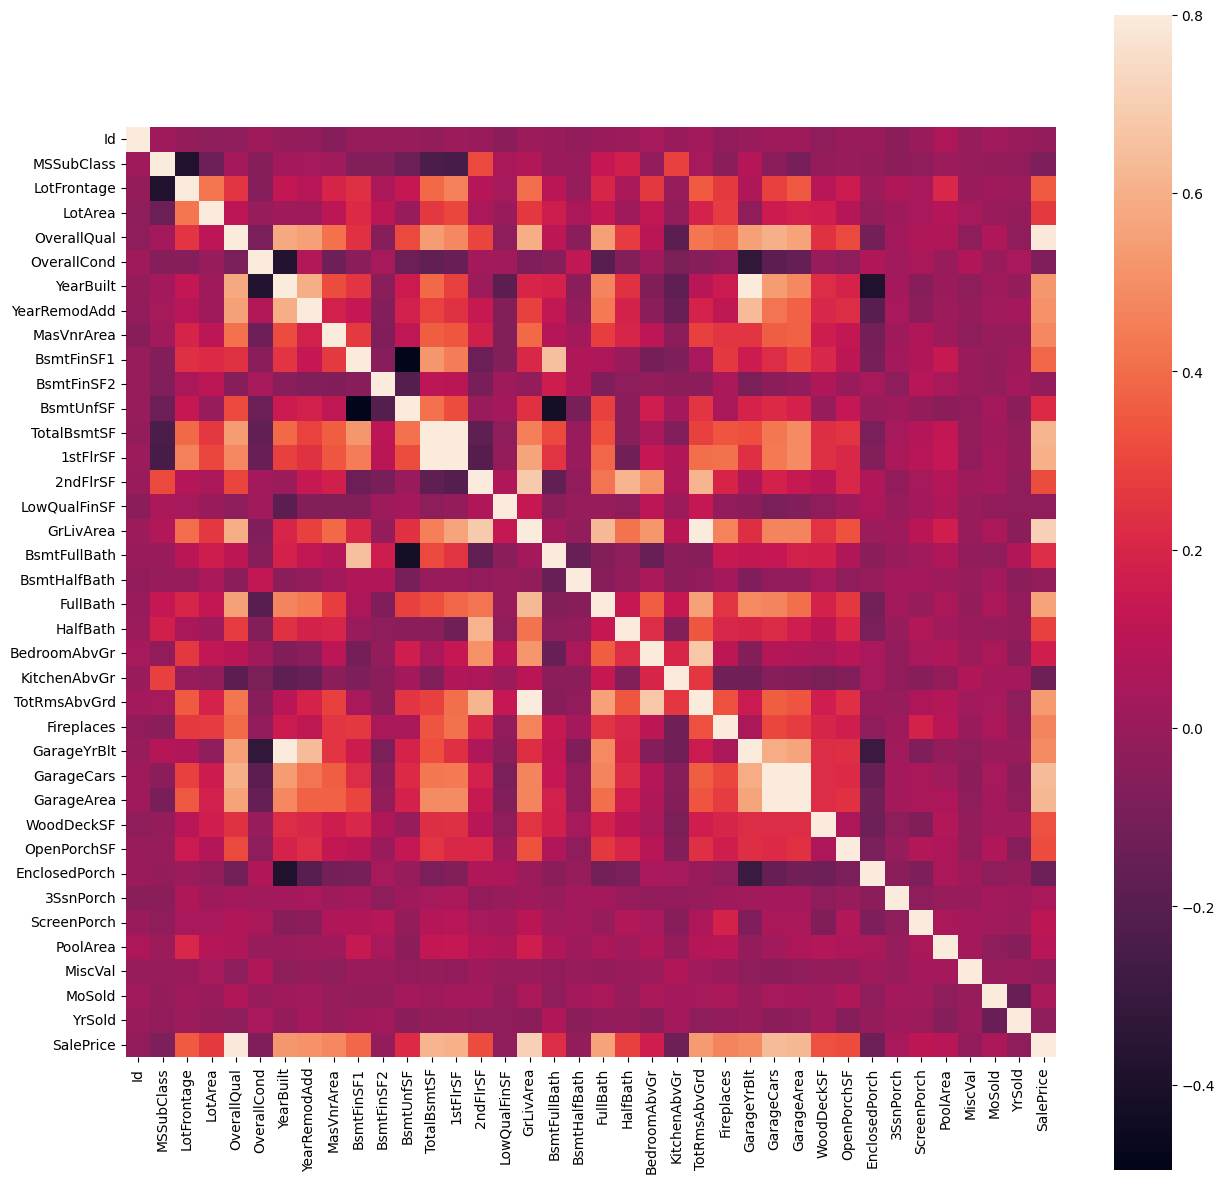

In [ ]:
# train_data = train_data[num_cols + cat_cols]
# train_data['Target'] = target

# C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

**One Hot Encode The Categorical Features :**

Most machine learning algorithms (e.g., linear regression, neural networks, etc.) can’t handle string categories directly. One-hot encoding transforms them into binary columns — one column per category.

🔸 Example
Suppose you have this column:
| Color |
|-------|
| Red   |
| Blue  |
| Green |
| Blue  |

After one-hot encoding, you get:

| Color   | Color_Red | Color_Blue | Color_Green |
|---------|-----------|------------|-------------|
| Red     | 1         | 0          | 0           |
| Blue    | 0         | 1          | 0           |
| Green   | 0         | 0          | 1           |
| Blue    | 0         | 1          | 0           |

In [ ]:
def oneHotEncode(df, colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col], axis = 1 , inplace=True)
    return df

In [ ]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))


There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [ ]:
combined

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,CentralAir_Y,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,856,854,0,1710,...,True,False,False,True,False,False,False,False,True,False
1,20,9600,6,8,1976,1976,1262,0,0,1262,...,True,False,False,True,False,False,False,False,True,False
2,60,11250,7,5,2001,2002,920,866,0,1786,...,True,False,False,True,False,False,False,False,True,False
3,70,9550,7,5,1915,1970,961,756,0,1717,...,True,False,False,True,True,False,False,False,False,False
4,60,14260,8,5,2000,2000,1145,1053,0,2198,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,1936,4,7,1970,1970,546,546,0,1092,...,True,False,False,True,False,False,False,False,True,False
2915,160,1894,4,5,1970,1970,546,546,0,1092,...,True,False,False,True,True,False,False,False,False,False
2916,20,20000,5,7,1960,1996,1224,0,0,1224,...,True,False,False,True,True,False,False,False,False,False
2917,85,10441,5,5,1992,1992,970,0,0,970,...,True,False,False,True,False,False,False,False,True,False


Now, split back combined dataFrame to training data and test data

In [ ]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test

In [ ]:
train, test = split_combined()

## Second : Make the Deep Neural Network
 * Define a sequential model
 * Add some dense layers
 * Use '**relu**' as the activation function in the hidden layers
 * Use a '**normal**' initializer as the kernal_intializer
           Initializers define the way to set the initial random weights of Keras layers.
 * We will use mean_absolute_error as a loss function
 * Define the output layer with only one node
 * Use 'linear 'as the activation function for the output layer



In [ ]:
NN_model = Sequential()

**The Input Layer**

In [ ]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

**The Hidden Layers**

In [ ]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

**The Output Layer**

In [ ]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

**Compile the network**

In [ ]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,857 (976.00 KB)

 Trainable params: 249,857 (976.00 KB)

 Non-trainable params: 0 (0.00 B)

**Define a checkpoint callback :**

In [ ]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.keras'

checkpoint = ModelCheckpoint(
    checkpoint_name,
    monitor='val_loss',
    verbose = 1,
    save_best_only = True,
    mode ='auto'
)

callbacks_list = [checkpoint]

## Third : Train the model :

In [ ]:
print(type(train), type(target))
print(train.dtype if hasattr(train, "dtype") else "no dtype")
print(target.dtype if hasattr(target, "dtype") else "no dtype")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
float32
float32


In [ ]:
import numpy as np

train = np.array(train).astype(np.float32)
target = np.array(target).astype(np.float32)

In [ ]:
target.shape, train.shape

((1460,), (1460, 149))

In [ ]:
NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 159192.4531 - mean_absolute_error: 159192.4531
Epoch 1: val_loss improved from inf to 53261.16797, saving model to Weights-001--53261.16797.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 158127.3906 - mean_absolute_error: 158127.3906 - val_loss: 53261.1680 - val_mean_absolute_error: 53261.1680
Epoch 2/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53939.6797 - mean_absolute_error: 53939.6797
Epoch 2: val_loss improved from 53261.16797 to 45715.94531, saving model to Weights-002--45715.94531.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 53584.0078 - mean_absolute_error: 53584.0078 - val_loss: 45715.9453 - val_mean_absolute_error: 45715.9453
Epoch 3/500
24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45428.0078 - mean_absolute_error: 45428.0078 
Epoch 3: val_loss improved from 45715.94531 to 42080.92969, saving model to Weights-003--42080.92969.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45015.5664 - me

In [ ]:
checkpoint_name

'Weights-{epoch:03d}--{val_loss:.5f}.keras'

List the generate checkpoint files, we will use those for the further inference.

In [ ]:
ls

sample_data/                    Weights-094--25271.57812.keras
Weights-001--53261.16797.keras  Weights-097--25198.25000.keras
Weights-002--45715.94531.keras  Weights-100--24841.63867.keras
Weights-003--42080.92969.keras  Weights-101--24761.03516.keras
Weights-005--38703.66406.keras  Weights-102--24230.43359.keras
Weights-006--37065.23047.keras  Weights-107--23824.52930.keras
Weights-007--36008.55078.keras  Weights-110--23786.51367.keras
Weights-008--35483.94922.keras  Weights-111--23335.86133.keras
Weights-009--35336.75000.keras  Weights-113--22833.73242.keras
Weights-011--35287.42969.keras  Weights-139--22109.41406.keras
Weights-012--34894.02734.keras  Weights-145--21875.05469.keras
Weights-015--34321.63281.keras  Weights-156--21771.36328.keras
Weights-021--34292.64844.keras  Weights-157--21450.89844.keras
Weights-024--33917.74609.keras  Weights-160--21425.97461.keras
Weights-028--33593.51562.keras  Weights-161--21355.38281.keras
Weights-033--33510.51953.keras  Weights-186--21229.6894

In [ ]:
# Load wights file of the best model :
# wights_file = 'Weights-486--18826.12891.hdf5' # choose the best checkpoint
wights_file = 'Weights-466--18402.88867.keras' # choose the best checkpoint

NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

We see that the validation loss of the best model is 14763.7256

## Fourth : Test the model
We will submit the predictions on the test data to Kaggle and see how good our model is.

In [ ]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('https://utilitiesfiles.s3.amazonaws.com/urban-analytic-class/test.csv').Id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

In [ ]:
test = np.array(test).astype(np.float32)
predictions = NN_model.predict(test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
predictions

array([[119287.055],
       [160065.72 ],
       [180134.72 ],
       ...,
       [153064.47 ],
       [141806.34 ],
       [211255.69 ]], dtype=float32)

With some more preprocessing, and more training, we can do better.


## Fifth: Try another ML algorithms :
Now, let us try another ML algorithm to compare the results.

We will use random forest regressor and XGBRegressor.

**Split training data to training and validation data**

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.25, random_state = 14)


**We will try Random forest model first.**

In [ ]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

RandomForestRegressor()

**Get the mean absolute error on the validation data **

In [ ]:
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  18102.375388127854


In [ ]:
predicted_prices = model.predict(test)
predicted_prices

array([131798.5       , 152510.85      , 175614.08      , ...,
       147237.        , 136637.28666667, 234943.47      ])

**Now, let us try XGBoost model**

In [ ]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

**Get the mean absolute error on the validation data**

In [ ]:
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  19475.021484375


**Make a submission file and submit it to Kaggle to see the result.**

In [ ]:
XGBpredictions = XGBModel.predict(test)


Isn't that a surprise, I really did not think that neural networks will beat random forests and XGBoost algorithms, but let us try not to be too optimistic, remember that we did not configure any hyperparameters on random forest and XGBoost models, I believe if we did so, these two models would outscore neural networks.